# **Predicting Customer Satisfaction**
## *Given survey data from an Airline, can we predict the satisfaction of a customer? *
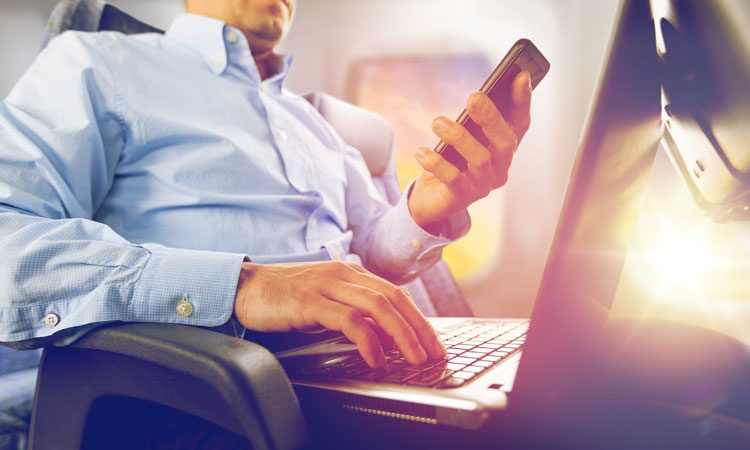

Welcome! This kernels aim is to showcase a few of the basics of data science (data cleaning, encoding, feature engineering, and model training), all while attempting to solve a problem that is common among businesses: *Customer Satisfaction*. 

We will be treating this as a binary classification problem, where we will attemp to create a model that predicts whether a customer was **Satisfied** or **Unsatisfied** with the experience and/or service which an airline provided.

**If you find this kernel helpful, please UPVOTE**

V10 - Fixed bug where test data was being set to train data

V9 - Initial Public Kernel


### Notes about the Dataset
This dataset has already been split into train and test csv files. 80% of the total dataset is in train.csv and 20% is in test.csv

In [21]:
import interpret

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\AIX360 = Tutorial to invoke LIME explainers.ipynb
data\datasets_74977_169835_StudentsPerformance.csv
data\Explaining Blackbox Classifiers.ipynb
data\student-performance-analysis.ipynb
data\test.csv
data\train.csv


In [23]:
directory = "data/"
feature_tables = ['train.csv', 'test.csv']

df_train = directory + feature_tables[0]
df_test = directory + feature_tables[1]

# Create dataframes
print(f'Reading csv from {df_train}...')
train = pd.read_csv(df_train)
print('...Complete')

print(f'Reading csv from {df_train}...')
test = pd.read_csv(df_test)
print('...Complete')

Reading csv from data/train.csv...
...Complete
Reading csv from data/train.csv...
...Complete


In [24]:
train.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   
4                                  3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 25 columns]

## Clean and Transform Dataset
Based on the training data above, there are several things we need to do in order to prepare the data for use in a model. There are several catagorical variables that need to be encoded, including our target variable 'Satisfaction'. There are also a couple of columns that are unnecessary, such as 'Unnamed:0' and 'id'. We can drop these. The functions below will be used to perform the dataset preparation.

In [25]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

train = process_data(train)
test = process_data(test)

In [26]:
train.head()

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       0              1   13               0      1              460   
1       0              0   25               1      2              235   
2       1              1   26               1      2             1142   
3       1              1   25               1      2              562   
4       0              1   61               1      2              214   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      3                                  4   
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   

   Ease of Online booking  Gate location  ...  Inflight entertainment  \
0                       3              1  ...                       5   
1                       3              3  ...                       1   
2                       2              2  ...                       5   
3                       5              5  ...                       2   
4                       3              3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes  satisfaction  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0             0  
4                       0.0             1  

[5 rows x 23 columns]

In [27]:
train.describe()

Gender  Customer Type            Age  Type of Travel  \
count  103904.000000  103904.000000  103904.000000   103904.000000   
mean        0.507459       0.817322      39.379706        0.689627   
std         0.499947       0.386404      15.114964        0.462649   
min         0.000000       0.000000       7.000000        0.000000   
25%         0.000000       1.000000      27.000000        0.000000   
50%         1.000000       1.000000      40.000000        1.000000   
75%         1.000000       1.000000      51.000000        1.000000   
max         1.000000       1.000000      85.000000        1.000000   

               Class  Flight Distance  Inflight wifi service  \
count  103904.000000    103904.000000          103904.000000   
mean        1.028103      1189.448375               2.729683   
std         0.962858       997.147281               1.327829   
min         0.000000        31.000000               0.000000   
25%         0.000000       414.000000               2.000000   
50%         1.000000       843.000000               3.000000   
75%         2.000000      1743.000000               4.000000   
max         2.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      103904.000000           103904.000000   
mean                            3.060296                2.756901   
std                             1.525075                1.398929   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  ...  Inflight entertainment  On-board service  \
count  103904.000000  ...           103904.000000     103904.000000   
mean        2.976883  ...                3.358158          3.382363   
std         1.277621  ...                1.332991          1.288354   
min         0.000000  ...                0.000000          0.000000   
25%         2.000000  ...                2.000000          2.000000   
50%         3.000000  ...                4.000000          4.000000   
75%         4.000000  ...                4.000000          4.000000   
max         5.000000  ...                5.000000          5.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count     103904.000000     103904.000000    103904.000000     103904.000000   
mean           3.351055          3.631833         3.304290          3.640428   
std            1.315605          1.180903         1.265396          1.175663   
min            0.000000          1.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max            5.000000          5.000000         5.000000          5.000000   

         Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
count  103904.000000               103904.000000             103904.000000   
mean        3.286351                   14.815618                 15.133392   
std         1.312273                   38.230901                 38.649776   
min         0.000000                    0.000000                  0.000000   
25%         2.000000                    0.000000                  0.000000   
50%         3.000000                    0.000000                  0.000000   
75%         4.000000                   12.000000                 13.000000   
max         5.000000                 1592.000000               1584.000000   

        satisfaction  
count  103904.000000  
mean        0.433333  
std         0.495538  
min         0.000000  
25%         0.

In [28]:
test.describe()

Gender  Customer Type           Age  Type of Travel  \
count  25976.000000   25976.000000  25976.000000    25976.000000   
mean       0.507083       0.815253     39.620958        0.694410   
std        0.499959       0.388100     15.135685        0.460666   
min        0.000000       0.000000      7.000000        0.000000   
25%        0.000000       1.000000     27.000000        0.000000   
50%        1.000000       1.000000     40.000000        1.000000   
75%        1.000000       1.000000     51.000000        1.000000   
max        1.000000       1.000000     85.000000        1.000000   

              Class  Flight Distance  Inflight wifi service  \
count  25976.000000     25976.000000           25976.000000   
mean       1.035841      1193.788459               2.724746   
std        0.961744       998.683999               1.335384   
min        0.000000        31.000000               0.000000   
25%        0.000000       414.000000               2.000000   
50%        1.000000       849.000000               3.000000   
75%        2.000000      1744.000000               4.000000   
max        2.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       25976.000000            25976.000000   
mean                            3.046812                2.756775   
std                             1.533371                1.412951   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  ...  Inflight entertainment  On-board service  \
count   25976.000000  ...            25976.000000      25976.000000   
mean        2.977094  ...                3.357753          3.385664   
std         1.282133  ...                1.338299          1.282088   
min         1.000000  ...                0.000000          0.000000   
25%         2.000000  ...                2.000000          2.000000   
50%         3.000000  ...                4.000000          4.000000   
75%         4.000000  ...                4.000000          4.000000   
max         5.000000  ...                5.000000          5.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      25976.000000      25976.000000     25976.000000      25976.000000   
mean           3.350169          3.633238         3.314175          3.649253   
std            1.318862          1.176525         1.269332          1.180681   
min            0.000000          1.000000         1.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max            5.000000          5.000000         5.000000          5.000000   

        Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
count  25976.000000                 25976.00000              25976.000000   
mean       3.286226                    14.30609                 14.693756   
std        1.319330                    37.42316                 37.466787   
min        0.000000                     0.00000                  0.000000   
25%        2.000000                     0.00000                  0.000000   
50%        3.000000                     0.00000                  0.000000   
75%        4.000000                    12.00000                 13.000000   
max        5.000000                  1128.00000               1115.000000   

       satisfaction  
count  25976.000000  
mean       0.438982  
std        0.496272  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       

In [29]:
train.isna()

Gender  Customer Type    Age  Type of Travel  Class  Flight Distance  \
0        False          False  False           False  False            False   
1        False          False  False           False  False            False   
2        False          False  False           False  False            False   
3        False          False  False           False  False            False   
4        False          False  False           False  False            False   
...        ...            ...    ...             ...    ...              ...   
103899   False          False  False           False  False            False   
103900   False          False  False           False  False            False   
103901   False          False  False           False  False            False   
103902   False          False  False           False  False            False   
103903   False          False  False           False  False            False   

        Inflight wifi service  Departure/Arrival time convenient  \
0                       False                              False   
1                       False                              False   
2                       False                              False   
3                       False                              False   
4                       False                              False   
...                       ...                                ...   
103899                  False                              False   
103900                  False                              False   
103901                  False                              False   
103902                  False                              False   
103903                  False                              False   

        Ease of Online booking  Gate location  ...  Inflight entertainment  \
0                        False          False  ...                   False   
1                        False          False  ...                   False   
2                        False          False  ...                   False   
3                        False          False  ...                   False   
4                        False          False  ...                   False   
...                        ...            ...  ...                     ...   
103899                   False          False  ...                   False   
103900                   False          False  ...                   False   
103901                   False          False  ...                   False   
103902                   False          False  ...                   False   
103903                   False          False  ...                   False   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                  False             False             False            False   
1                  False             False             False            False   
2                  False             False             False            False   
3                  False             False             False            False   
4                  False             False             False            False   
...                  ...               ...               ...              ...   
103899             False             False             False            False   
103900             False             False             False            False   
103901             False             False             False            False   
103902             False             False             False            False   
103903             False             False             False            False   

        Inflight service  Cleanliness  Departure Delay in Minutes  \
0                  False        False                       False   
1                  False        False                       False   
2                  False        False                       False   
3                  False        False       

In [31]:
test.isna()

Gender  Customer Type    Age  Type of Travel  Class  Flight Distance  \
0       False          False  False           False  False            False   
1       False          False  False           False  False            False   
2       False          False  False           False  False            False   
3       False          False  False           False  False            False   
4       False          False  False           False  False            False   
...       ...            ...    ...             ...    ...              ...   
25971   False          False  False           False  False            False   
25972   False          False  False           False  False            False   
25973   False          False  False           False  False            False   
25974   False          False  False           False  False            False   
25975   False          False  False           False  False            False   

       Inflight wifi service  Departure/Arrival time convenient  \
0                      False                              False   
1                      False                              False   
2                      False                              False   
3                      False                              False   
4                      False                              False   
...                      ...                                ...   
25971                  False                              False   
25972                  False                              False   
25973                  False                              False   
25974                  False                              False   
25975                  False                              False   

       Ease of Online booking  Gate location  ...  Inflight entertainment  \
0                       False          False  ...                   False   
1                       False          False  ...                   False   
2                       False          False  ...                   False   
3                       False          False  ...                   False   
4                       False          False  ...                   False   
...                       ...            ...  ...                     ...   
25971                   False          False  ...                   False   
25972                   False          False  ...                   False   
25973                   False          False  ...                   False   
25974                   False          False  ...                   False   
25975                   False          False  ...                   False   

       On-board service  Leg room service  Baggage handling  Checkin service  \
0                 False             False             False            False   
1                 False             False             False            False   
2                 False             False             False            False   
3                 False             False             False            False   
4                 False             False             False            False   
...                 ...               ...               ...              ...   
25971             False             False             False            False   
25972             False             False             False            False   
25973             False             False             False            False   
25974             False             False             False            False   
25975             False             False             False            False   

       Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 False        False                       False   
1                 False        False                       False   
2                 False        False                       False   
3                 False        False                       False   
4                 False    

Nice! We now have every feature properly coded, almost time to start creating some models! But first, we will want to normalize our dataset via StandardScaler. Even if the model you are using does not care about a normalized dataset, I still like to do it just out of routine.

In [9]:
#Define our features and target (this is helpful in case you would like to drop any features that harm model performance)
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Normalization Complete! Also, just for kicks, lets take a look at a correlation heatmap to see which features correlate well with customer satisfaction.
* **Best features** - Online Booking, Class, and Type of Travel
* **Worst features** - Gate location, Gender, and Departure/Arrival Time Convenient

We will keep all of our features in for now, but can always return to this step in case we want to drop features.

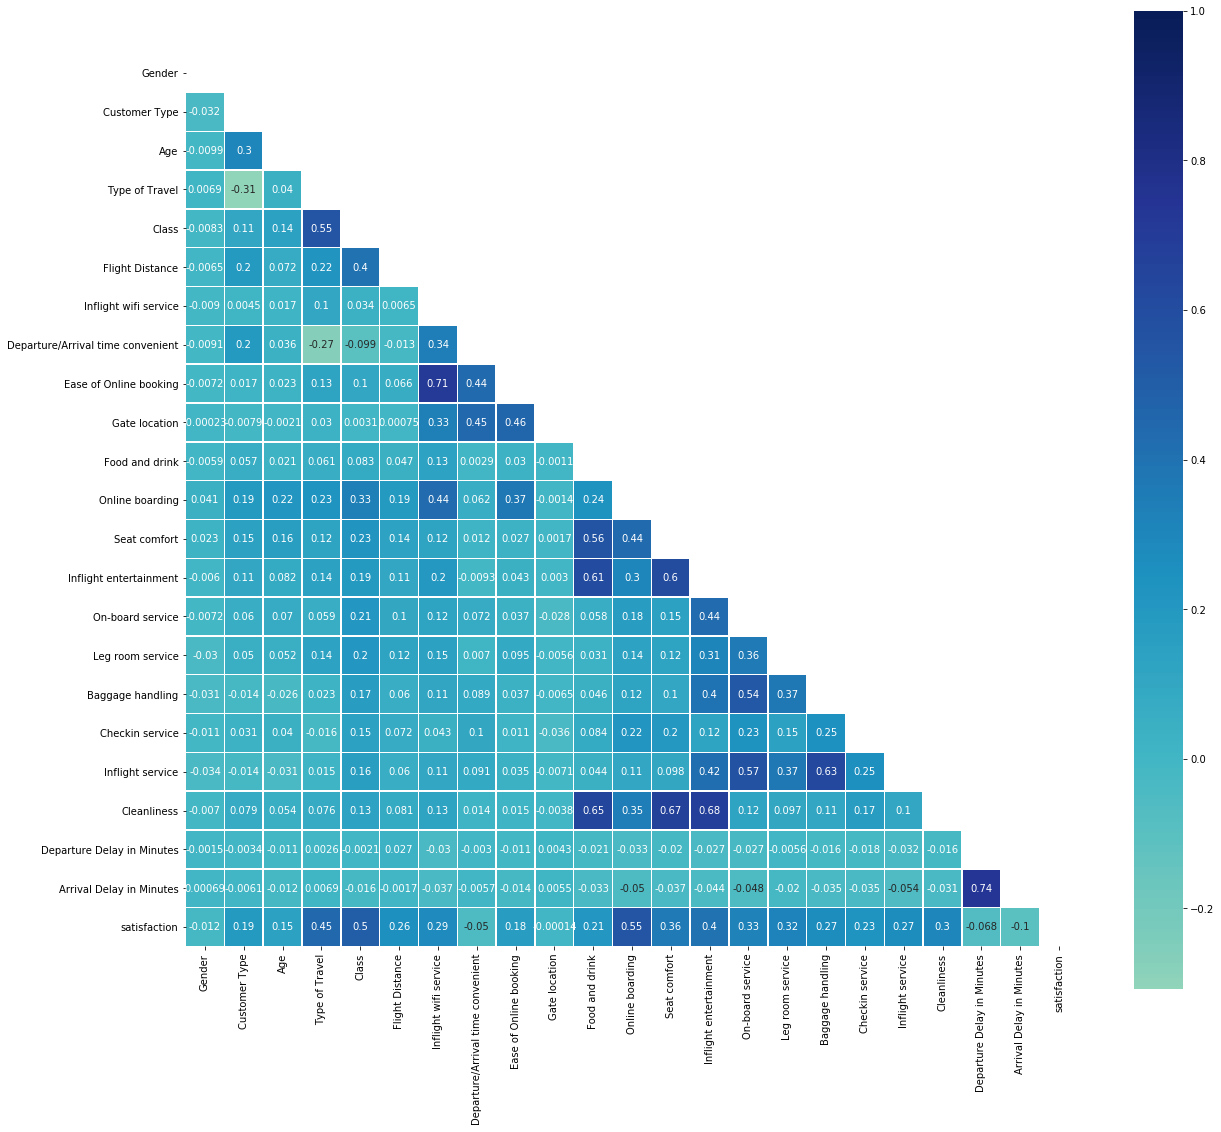

In [10]:
corr = train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

## Model Evaluation

Now to the models! We will be trying out a few different models to see which one is the best choice for our problem. I have created a small function below which will train, predict, and evaluate all of our models. We will be evaluating performance of our models with the ROC_AUC metric. This metric is good for classification of a dataset which a relatively balance dataset in terms of our target. We will also be looking at the confusion matrix for our model to best understand how our model is mischaracterizing predictions (Are we seeing majority false positives? etc.) 

Note that I did some hyperparameter tuning on some of the models, but not all. I will be publishing another kernel showing how to tune hyperparameters, so stay tuned!

In [11]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

### Random Forest 

A great place to start! We are seeing an accuracy of 96.30%. Lets see if the other models can compare.

ROC_AUC = 0.9607290873474874
              precision    recall  f1-score   support

           0    0.95556   0.97969   0.96747     14573
           1    0.97318   0.94177   0.95722     11403

    accuracy                        0.96304     25976
   macro avg    0.96437   0.96073   0.96234     25976
weighted avg    0.96329   0.96304   0.96297     25976



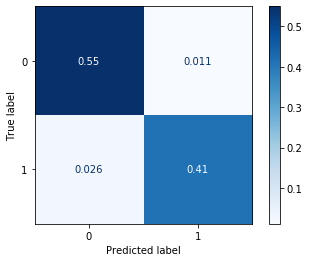

In [12]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

In [15]:
from interpret.blackbox import LimeTabular
from interpret import show


#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=model_rf.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:1], y_test[:1], name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7217/1770665982024/ -->

### Catboost

Pretty good for not having tuned hyperparameters here. Expect a performance boost once that is completed.

ROC_AUC = 0.9621246776435761
              precision    recall  f1-score   support

           0    0.95822   0.97880   0.96840     14573
           1    0.97214   0.94545   0.95861     11403

    accuracy                        0.96416     25976
   macro avg    0.96518   0.96212   0.96350     25976
weighted avg    0.96433   0.96416   0.96410     25976



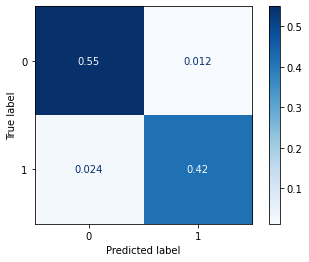

In [11]:
params_cb ={}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, roc_auc_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

### LightGBM

Not bad LightGBM! But not quite up at 'Random Forest' levels. Lets keep going!

ROC_AUC = 0.9621206999312578
              precision    recall  f1-score   support

           0    0.95688   0.98072   0.96865     14573
           1    0.97455   0.94352   0.95878     11403

    accuracy                        0.96439     25976
   macro avg    0.96571   0.96212   0.96372     25976
weighted avg    0.96464   0.96439   0.96432     25976



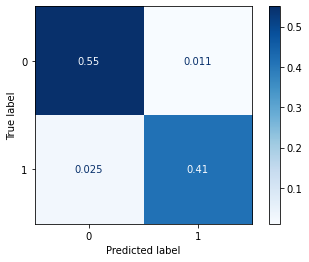

In [12]:
params_lgb ={'colsample_bytree': 0.85, 
         'max_depth': 15, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, roc_auc_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

### XGBoost

I expected more from you XGBoost ;)

ROC_AUC = 0.9613126285764666
              precision    recall  f1-score   support

           0    0.95778   0.97770   0.96764     14573
           1    0.97072   0.94493   0.95765     11403

    accuracy                        0.96331     25976
   macro avg    0.96425   0.96131   0.96264     25976
weighted avg    0.96346   0.96331   0.96325     25976



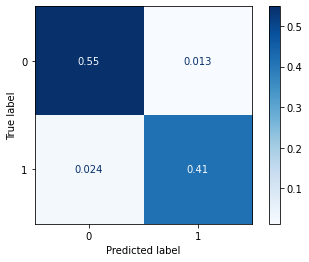

In [13]:
params_xgb ={}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

## Model Comparison and Conclusions

Based on the roc_auc metric, we have a clean winner. Our Random forest classifier outperformed all of our other models. One thing to keep in mind is that both the Catboost and the XGBoost classifiers just used default parameters without any hyperparameter tuning. 

In [14]:
auc_scores = [roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
model_scores = pd.DataFrame(auc_scores, index=['Random Forest','LightGBM','Catboost','XGBoost'], columns=['AUC'])
model_scores.head()

AUC
Random Forest  0.960729
LightGBM       0.962121
Catboost       0.962125
XGBoost        0.961313

## Can you improve on my best models performance? What factors led instances of mis-classification? Try new things!

## UPVOTE if you found this helpful, insightful, intriquing, interesting, or other adjectives!

In [20]:
from interpret.blackbox import LimeTabular
from interpret import show


#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=model_cb.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:1], y_test[:1], name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7926/2191172059432/ -->

In [17]:
from interpret.blackbox import LimeTabular
from interpret import show


#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=model_lgb.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:1], y_test[:1], name='LIME')

show(lime_local)

C:\Users\Daniel_Pietschmann\anaconda3\envs\interpret\lib\site-packages\lightgbm\basic.py:253: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

C:\Users\Daniel_Pietschmann\anaconda3\envs\interpret\lib\site-packages\lightgbm\basic.py:253: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.



<!-- http://127.0.0.1:7602/2221038908528/ -->

In [18]:
from interpret.blackbox import LimeTabular
from interpret import show


#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=model_xgb.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:1], y_test[:1], name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7602/2221037531488/ -->

In [23]:
show([model_rf, model_xgb])

AttributeError: 'RandomForestClassifier' object has no attribute 'selector'